In [5]:
# 以下のサイトを解釈
# https://www.r-bloggers.com/confidence-intervals-for-prediction-in-glmms/

In [61]:
library(Matrix)
library(lme4)
 
#first case simple lmer, simulate 100 data points from 10 groups with one continuous fixed effect variable

#[0,10]の一様乱数を100個生成
x<-runif(100,0,10)

#10levelのファクターを10個ずつ生成
f<-gl(n = 10,k = 10)

#あらかじめ前処理としてmodel.matrix（どの列が説明変数で、どの列が応答変数なのかの情報をmatrixに含ませたもの）を生成
data<-data.frame(x=x,f=f)
modmat<-model.matrix(~x,data)

#the fixed effect coefficient 固定効果係数
fixed<-c(1,0.5)
#the random effect ランダム効果10個
rnd<-rnorm(10,0,0.7)
#the simulated response values 応答変数100個
data$y<-rnorm(100,modmat%*%fixed+rnd[f],0.3)

In [31]:
#方針はこちらに記載

#http://bbolker.github.io/mixedmodels-misc/glmmFAQ.html

#The general recipe for computing predictions from a linear or generalized linear model is to

#figure out the model matrix X corresponding to the new data;
#matrix-multiply X by the parameter vector β to get the predictions (or linear predictor in the case of GLM(M)s);
#extract the variance-covariance matrix of the parameters V
#compute XVX′ to get the variance-covariance matrix of the predictions;
#extract the diagonal of this matrix to get variances of predictions;
#if computing prediction rather than confidence intervals, add the residual variance;
#take the square-root of the variances to get the standard deviations (errors) of the predictions;
#compute confidence intervals based on a Normal approximation;
#for GL(M)Ms, run the confidence interval boundaries (not the standard errors) through the inverse-link function.

In [62]:
#model
m<-lmer(y~x+(1|f),data)
 
#first CI and PI using predict-like method, using code posted here: http://glmm.wikidot.com/faq
newdat<-data.frame(x=seq(0,10,length=20))
mm<-model.matrix(~x,newdat)

newdat$y<-mm%*%fixef(m)    #fixef()はmの固定効果係数
#predict(m,newdat,re.form=NA) would give the same results  #re.form=NAでランダム効果を含まず予測する
pvar1 <- diag(mm %*% tcrossprod(vcov(m),mm))  #tcrossprod:転置した積を求める vov(m):2*2の分散共分散行列
tvar1 <- pvar1+VarCorr(m)$f[1] # must be adapted for more complex models  #VarCorr(m):ランダム効果の分散共分散 ⇒$fで分散を取り出して[1]で定数にしてる VarCorr()だと表示は標準偏差
newdat <- data.frame(
  newdat
  , plo = newdat$y-1.96*sqrt(pvar1)
  , phi = newdat$y+1.96*sqrt(pvar1)
  , tlo = newdat$y-1.96*sqrt(tvar1)
  , thi = newdat$y+1.96*sqrt(tvar1)
)

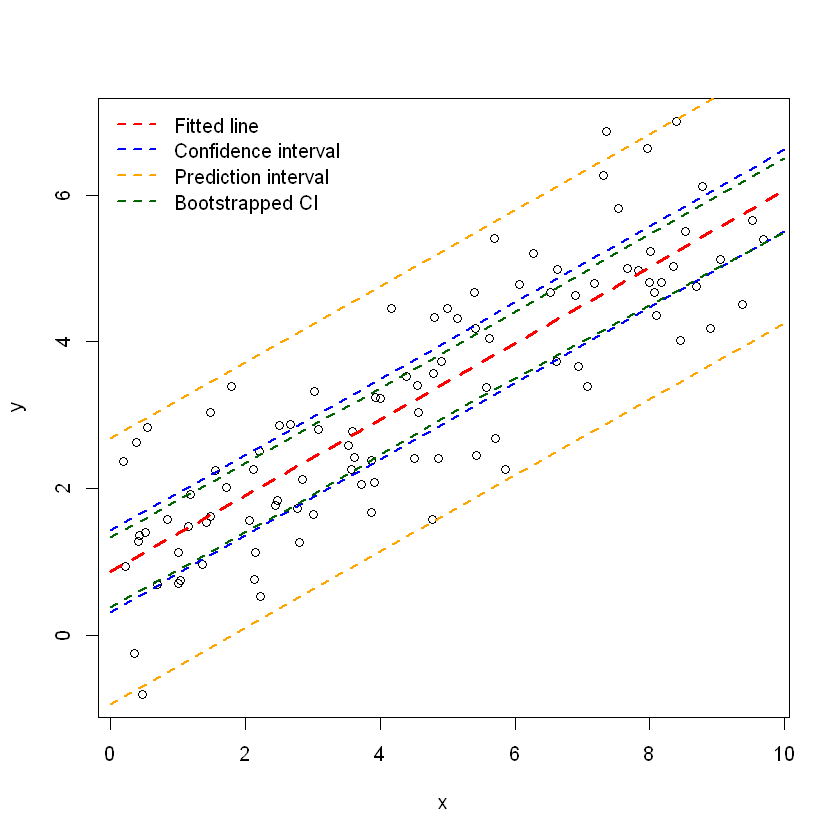

In [84]:
#second version with bootMer
#we have to define a function that will be applied to the nsim simulations
#here we basically get a merMod object and return the fitted values
predFun<-function(.) mm%*%fixef(.) 
bb<-bootMer(m,FUN=predFun,nsim=200) #do this 200 times  #bb$tは200*20の行列
#as we did this 200 times the 95% CI will be bordered by the 5th and 195th value
bb_se<-apply(bb$t,2,function(x) x[order(x)]) #200*20の行列  #applyの自作関数版で縦に適用
newdat$blo<-bb_se[5,]
newdat$bhi<-bb_se[195,]

plot(y~x,data)
lines(newdat$x,newdat$y,col="red",lty=2,lwd=3)
lines(newdat$x,newdat$plo,col="blue",lty=2,lwd=2)
lines(newdat$x,newdat$phi,col="blue",lty=2,lwd=2)
lines(newdat$x,newdat$tlo,col="orange",lty=2,lwd=2)
lines(newdat$x,newdat$thi,col="orange",lty=2,lwd=2)
lines(newdat$x,newdat$bhi,col="darkgreen",lty=2,lwd=2)
lines(newdat$x,newdat$blo,col="darkgreen",lty=2,lwd=2)
legend("topleft",legend=c("Fitted line","Confidence interval","Prediction interval","Bootstrapped CI"),col=c("red","blue","orange","darkgreen"),lty=2,lwd=2,bty="n")

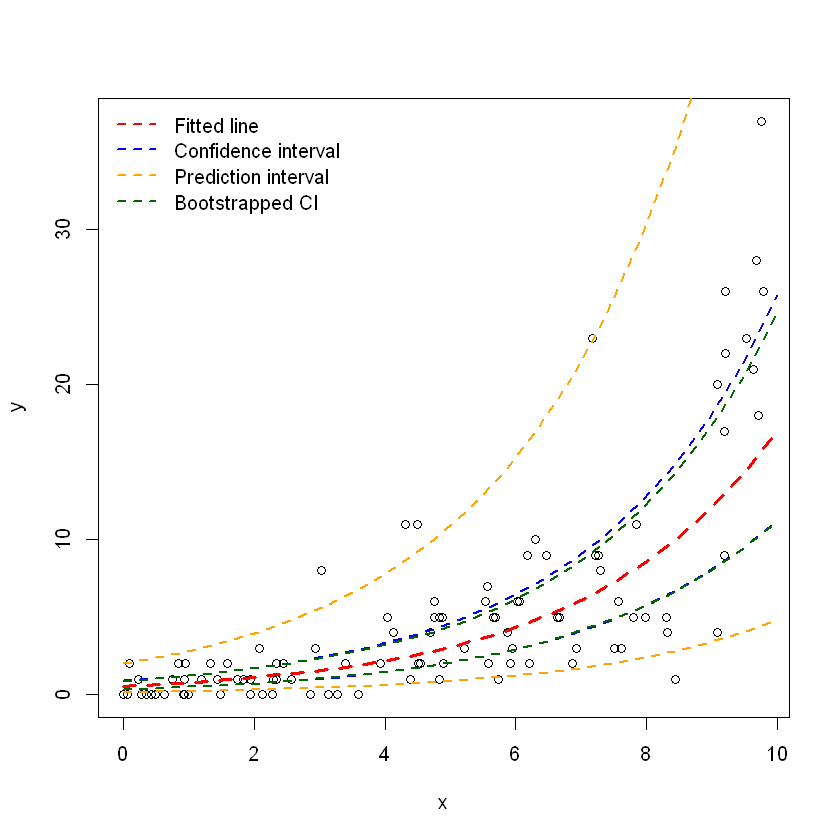

In [86]:
#second case more complex design with two crossed RE and a poisson response
x<-runif(100,0,10)
f1<-gl(n = 10,k = 10)
f2<-as.factor(rep(1:10,10))
data<-data.frame(x=x,f1=f1,f2=f2)
modmat<-model.matrix(~x,data)
 
fixed<-c(-0.12,0.35)
rnd1<-rnorm(10,0,0.7)
rnd2<-rnorm(10,0,0.2)
 
mus<-modmat%*%fixed+rnd1[f1]+rnd2[f2]
data$y<-rpois(100,exp(mus))
 
m<-glmer(y~x+(1|f1)+(1|f2),data,family="poisson")
 
#for GLMMs we have to back-transform the prediction after adding/removing the SE
newdat<-data.frame(x=seq(0,10,length=20))
mm<-model.matrix(~x,newdat)
y<-mm%*%fixef(m)
pvar1 <- diag(mm %*% tcrossprod(vcov(m),mm))
tvar1 <- pvar1+VarCorr(m)$f1[1]+VarCorr(m)$f2[1]  ## must be adapted for more complex models
newdat <- data.frame(
  x=newdat$x,
  y=exp(y),
   plo = exp(y-1.96*sqrt(pvar1))
  , phi = exp(y+1.96*sqrt(pvar1))
  , tlo = exp(y-1.96*sqrt(tvar1))
  , thi = exp(y+1.96*sqrt(tvar1))
)
 
#second version with bootMer
predFun<-function(.) exp(mm%*%fixef(.)) 
bb<-bootMer(m,FUN=predFun,nsim=200)
bb_se<-apply(bb$t,2,function(x) x[order(x)])
newdat$blo<-bb_se[5,]
newdat$bhi<-bb_se[195,]
 
#plot
plot(y~x,data)
lines(newdat$x,newdat$y,col="red",lty=2,lwd=3)
lines(newdat$x,newdat$plo,col="blue",lty=2,lwd=2)
lines(newdat$x,newdat$phi,col="blue",lty=2,lwd=2)
lines(newdat$x,newdat$tlo,col="orange",lty=2,lwd=2)
lines(newdat$x,newdat$thi,col="orange",lty=2,lwd=2)
lines(newdat$x,newdat$bhi,col="darkgreen",lty=2,lwd=2)
lines(newdat$x,newdat$blo,col="darkgreen",lty=2,lwd=2)
legend("topleft",legend=c("Fitted line","Confidence interval","Prediction interval","Bootstrapped CI"),col=c("red","blue","orange","darkgreen"),lty=2,lwd=2,bty="n")